In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import files
files.upload()
! rm -rf ~/.kaggle/
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [0]:
! pip install -q kaggle

In [6]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=b2e913de5b18616b84272768646b6cbc0a3ea871bede474dd8bcf2ad0495f172
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Kaggle API 1.5.6


In [7]:
! kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:16<00:00, 72.3MB/s]
100% 812M/812M [00:16<00:00, 52.9MB/s]


In [8]:
! mkdir dogs-vs-cats
! unzip dogs-vs-cats -d dogs-vs-cats

Archive:  dogs-vs-cats.zip
  inflating: dogs-vs-cats/sampleSubmission.csv  
  inflating: dogs-vs-cats/test1.zip  
  inflating: dogs-vs-cats/train.zip  


In [0]:
! mkdir train
! unzip dogs-vs-cats/train -d train
! mkdir test
! unzip dogs-vs-cats/test1 -d test

In [0]:
! mkdir train/train/dog/
! mkdir train/train/cat/

In [0]:
!mv train/train/cat.* train/train/cat
!mv train/train/dog.* train/train/dog

In [0]:
!mkdir validation/
!mkdir validation/cat/
!mkdir validation/dog/
!mv train/train/cat/cat.1????.jpg validation/cat/
!mv train/train/dog/dog.1????.jpg validation/dog/

In [0]:
train_dir = 'train/train/'
validation_dir = 'validation'
train_cats_dir = 'train/train/cat/'  
train_dogs_dir = 'train/train/dog/'
validation_cats_dir = 'validation/cat/'  
validation_dogs_dir = 'validation/dog/'  

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

Задание 1.
Загрузите данные. Разделите исходный набор данных на обучающую, валидационную и контрольную выборки.


In [14]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 10000
total training dog images: 10000
total validation cat images: 2500
total validation dog images: 2500
--
Total training images: 20000
Total validation images: 5000


In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) 
validation_image_generator = ImageDataGenerator(rescale=1./255) 

In [17]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 20000 images belonging to 2 classes.


In [18]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 5000 images belonging to 2 classes.


In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

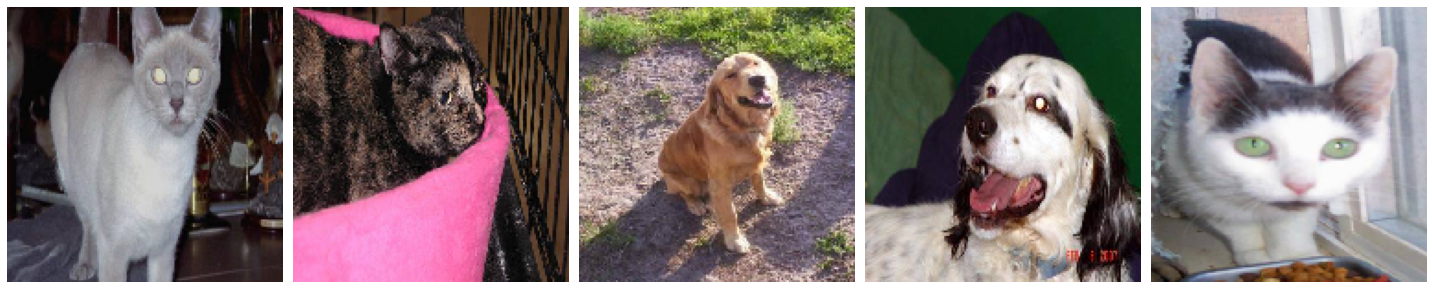

In [21]:
plotImages(sample_training_images[:5])

Задание 2.
Реализуйте глубокую нейронную сеть с как минимум тремя сверточными слоями. Какое качество классификации получено?


In [22]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [23]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
156/156 [==============================] - 68s 433ms/step - loss: 0.6665 - accuracy: 0.6072 - val_loss: 0.5728 - val_accuracy: 0.7286
Epoch 2/15
156/156 [==============================] - 65s 420ms/step - loss: 0.5068 - accuracy: 0.7350 - val_loss: 0.4923 - val_accuracy: 0.7360
Epoch 3/15
156/156 [==============================] - 69s 440ms/step - loss: 0.4463 - accuracy: 0.7803 - val_loss: 0.4394 - val_accuracy: 0.7867
Epoch 4/15
156/156 [==============================] - 66s 424ms/step - loss: 0.3983 - accuracy: 0.8095 - val_loss: 0.4365 - val_accuracy: 0.7917
Epoch 5/15
156/156 [==============================] - 65s 419ms/step - loss: 0.3430 - accuracy: 0.8429 - val_loss: 0.4159 - val_accuracy: 0.7905
Epoch 6/15
156/156 [==============================] - 65s 417ms/step - loss: 0.3068 - accuracy: 0.8607 - val_loss: 0.4130 - val_accuracy: 0.8159
Epoch 7/15
156/156 [==============================] - 

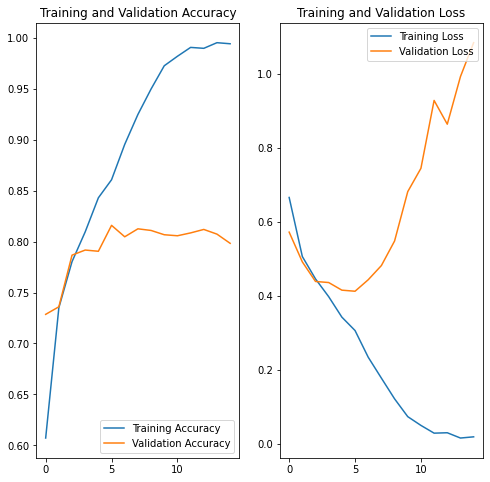

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Задание 3.
Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 


Found 20000 images belonging to 2 classes.


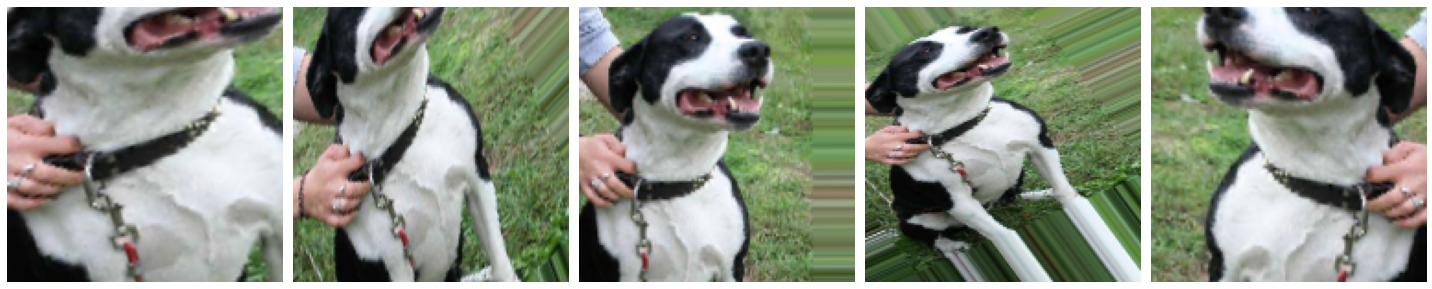

In [25]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [27]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 5000 images belonging to 2 classes.


In [28]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)            

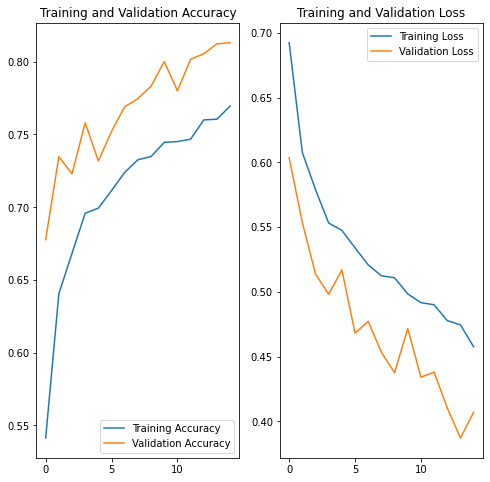

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Качество улучшилось

Задание 4.
Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора?
Какой максимальный результат удалось получить на сайте Kaggle? Почему?


In [0]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [31]:
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)       

In [32]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
156/156 [==============================] - 142s 913ms/step - loss: 0.7345 - accuracy: 0.5038 - val_loss: 0.6739 - val_accuracy: 0.5024
Epoch 2/15
156/156 [==============================] - 141s 904ms/step - loss: 0.6669 - accuracy: 0.5460 - val_loss: 0.6295 - val_accuracy: 0.6104
Epoch 3/15
156/156 [==============================] - 142s 908ms/step - loss: 0.6273 - accuracy: 0.6210 - val_loss: 0.5993 - val_accuracy: 0.6294
Epoch 4/15
156/156 [==============================] - 142s 910ms/step - loss: 0.5932 - accuracy: 0.6558 - val_loss: 0.5596 - val_accuracy: 0.6388
Epoch 5/15
156/156 [==============================] - 140s 900ms/step - loss: 0.5783 - accuracy: 0.6693 - val_loss: 0.5184 - val_accuracy: 0.6877
Epoch 6/15
156/156 [==============================] - 141s 905ms/step - loss: 0.5563 - accuracy: 0.6910 - val_loss: 0.5012 - val_accuracy: 0.6935
Epoch 7/15
156/156 [==============================] - 141s 906ms/step - loss: 0.5455 - accuracy: 0.7024 - val_loss: 0.4826 -

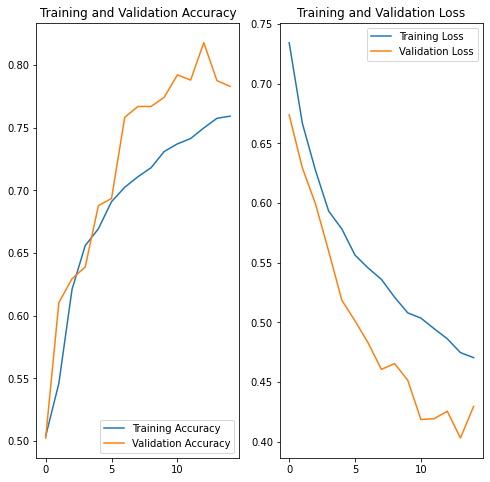

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model

base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x)
preds=Dense(1,activation='softmax')(x) 
model=Model(inputs=base_model.input,outputs=preds)
model.summary()
for layer in model.layers:
    layer.trainable=False
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

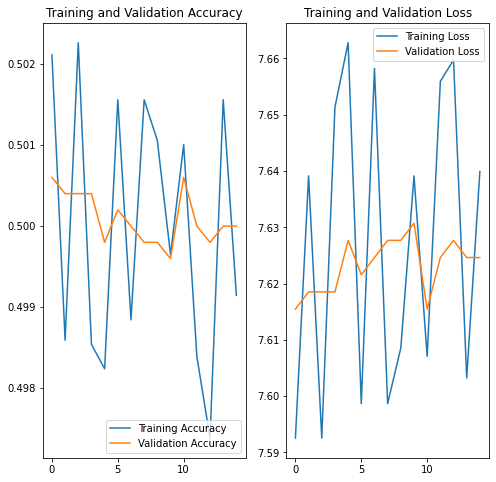

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()